# Select dispatching rule using deep q reinforcement learning

# Prepare programming environment

## Load necessary packages

In [1]:
# Import packages
import sys
from tensorforce.environments import Environment
from datetime import datetime
from time import mktime
from tensorforce.agents import Agent
import pandas as pd
import pickle
import seaborn as sns

sys.path.append("..")
from src.simulation import assign_priority_edd, assign_priority_mdd, assign_priority_spt, assign_priority_srpt, assign_priority_lpt, assign_priority_cr, assign_priority_ds, assign_priority_fifo, select_machine_winq
from src.models import SelectEnvironment, hyperparameter_tuning, run_agent, PlantEnv

# Register the plant class
PlantEnv.register()

## Get required data

In [2]:
# Load data required for simulation
product_types_df = pd.read_csv("../data/external/product_types.csv")
product_types_df = product_types_df[product_types_df.id != 2]
with open(r"../data/interim/sim_data.pickle", "rb") as output_file:
    orders_df = pickle.load(output_file)
machines_df = pd.read_csv("../data/external/machine.csv")
machines_df = machines_df[machines_df.product_type_id != 2]

## Define constants

In [3]:
# Define constants for simulation
priority_rules = [assign_priority_edd, assign_priority_spt, assign_priority_srpt, assign_priority_fifo, assign_priority_cr,
                  assign_priority_mdd, assign_priority_lpt, assign_priority_ds]
SIMULATION_START = mktime(datetime(2022, 11, 14, 5, 0, 0).timetuple()) * 1000
due_date_range_list = [(3, 10), (5, 14), (7, 21)]
number_orders_start_list = [80, 90, 100, 110]
average_count_new_orders_list = [80, 90, 100, 110]
worker_list =  [40, 50, 60, 70]
random_states = [7, 42, 66, 97, 108]
random_states_evaluation = [100, 101, 102]

# Prepare training

In [4]:
# Create learning environment
environment = Environment.create(
    environment=SelectEnvironment(product_types_df, machines_df, orders_df,priority_rules=priority_rules,
                 simulation_start=SIMULATION_START, allocation_rule=select_machine_winq, random_state=42))

# Hyperparameter tuning

In [5]:
# Parameter grid for deep q learning
params_q = {"batch_size": [5, 30],
            "update_frequency": [0.25, 0.5, 1.0],
            "horizon": [5, 30],
            "discount": [0.9, 0.5, 0.01],
            "return_processing": [dict(type='exponential_normalization', decay=0.9), None],
            "reward_processing": [dict(type='exponential_normalization', decay=0.9), None],
            "state_preprocessing": [dict(type='exponential_normalization', decay=0.9),  None],
            "target_update_weight": [0.7, 1.0],
            "l2_regularization": [0.01, 0.0],
            }

In [6]:
# Execute hyperparameter search
# tuning_res = hyperparameter_tuning(environment, params_q, 1, due_date_range_list, number_orders_start_list,
#                         average_count_new_orders_list, worker_list, [42], 3)

In [7]:
# Save results of hyperparameter search
# tuning_res.to_csv("../data/processed/hyperparameter_search/results_hyperparameter_select_deep_q_learning.csv", index = False)

In [8]:
# Read hyperparameter results
tuning_res = pd.read_csv("../data/processed/hyperparameter_search/results_hyperparameter_select_deep_q_learning.csv")

In [9]:
# Show best performing combination
tuning_res.sort_values(["reward_training_mean", "reward_evaluation_mean"], ascending = False)

,batch_size,update_frequency,horizon,discount,return_processing,state_preprocessing,reward_processing,target_update_weight,l2_regularization,reward_training_mean,reward_training_var,reward_evaluation_mean,reward_evaluation_var,reward_df
26,5,0.5,30,0.90,NaN,NaN,NaN,0.7,0.01,8176.041143,2.227054e+07,6119.041612,2.477160e+07,episode day reward due_date_range...
63,5,0.5,30,0.90,NaN,NaN,NaN,0.7,0.00,8167.411602,2.234050e+07,6127.736844,2.438002e+07,episode day reward due_date_range...
38,30,0.5,5,0.90,NaN,NaN,NaN,1.0,0.01,8165.938390,2.214403e+07,6174.388806,2.537082e+07,episode day reward due_date_range...
161,5,1.0,30,0.50,NaN,NaN,NaN,0.7,0.01,8153.888962,2.247067e+07,6099.959301,2.564236e+07,episode day reward due_date_rang...
179,30,0.5,5,0.90,NaN,NaN,NaN,0.7,0.00,8121.865734,2.231287e+07,6109.413542,2.601128e+07,episode day reward due_date_rang...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,5,0.5,30,0.90,NaN,"{'type': 'exponential_normalization', 'decay':...",NaN,0.7,0.00,6989.503386,2.536119e+07,5213.493603,2.947091e+07,episode day reward due_date_range...
34,5,1.0,5,0.01,NaN,"{'type': 'exponential_normalization', 'decay':...",NaN,1.0,0.00,6950.360795,2.569203e+07,5275.553131,2.868677e+07,episode day reward due_date_range...
152,30,1.0,30,0.01,NaN,"{'type': 'exponential_normalization', 'decay':...",NaN,0.7,0.01,6863.783064,2.574048e+07,5131.338146,2.876212e+07,episode day reward due_date_range...
18,5,0.5,30,0.01,NaN,"{'type': 'exponential_normalization', 'decay':...",NaN,1.0,0.01,6821.040351,2.530350e+07,5065.431576,2.920767e+07,episode day reward due_date_range...


# Define and train final model

In [10]:
# Define agent based on hyperparameter results
agent = Agent.create(
    agent='dqn', environment=environment, memory=90, batch_size=30, update_frequency=0.5, horizon=5, discount=0.9,
    summarizer=dict(
        directory='summaries/select/deepq',
        summaries=["action-value", "entropy", "graph", "kl-divergence", "loss", "parameters", "reward", "update-norm",
                   "updates", "variables"]
    ), learning_rate=0.001, return_processing=None, state_preprocessing=None,
    reward_processing=None,
    target_update_weight=0.7, exploration=0.2, l2_regularization=0.01)

In [11]:
# Run agent for 100 episodes to train it
# Duration ~ 30 hours
# rewards_list = run_agent(agent, environment, due_date_range_list,number_orders_start_list,
#                         average_count_new_orders_list, worker_list, random_states, episodes = 120, evaluate = False)

In [12]:
# Save models
# agent.save(directory="../models/select_deep_q")

# Evaluate model

In [13]:
# %load_ext tensorboard

In [14]:
# Analysis of learning process
# File is larger than 100 GB and was therefore no shared
# %tensorboard --logdir summaries/select/deepq

In [15]:
# Run agent for evaluation
# Duration ~ 8 minutes
# rewards_list_evaluation = run_agent(agent, environment, due_date_range_list,number_orders_start_list, average_count_new_orders_list, worker_list, random_states_evaluation, episodes = 1, evaluate = True)

In [16]:
# Save results
# rewards_list_evaluation.to_csv("../data/processed/evaluation/simulation_results_validation_select_deep_q_learning.csv", index = False)

In [17]:
# Load results
rewards_list_evaluation = pd.read_csv("../data/processed/evaluation/simulation_results_validation_select_deep_q_learning.csv")

In [18]:
# Calculate mean reward
rewards_list_evaluation["reward"].mean()

8271.915735350634

<AxesSubplot: xlabel='day', ylabel='reward'>

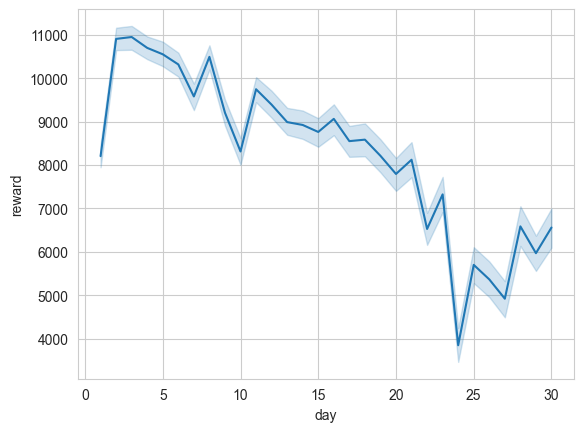

In [19]:
# Visualize profit
sns.lineplot(rewards_list_evaluation, x = "day", y = "reward")

<AxesSubplot: xlabel='day', ylabel='reward'>

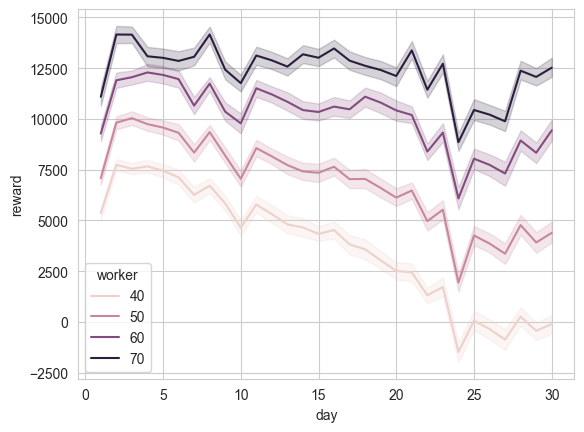

In [20]:
# Visualize profit per worker constellation
sns.lineplot(rewards_list_evaluation, x = "day", y = "reward", hue = "worker")

<AxesSubplot: xlabel='day', ylabel='reward'>

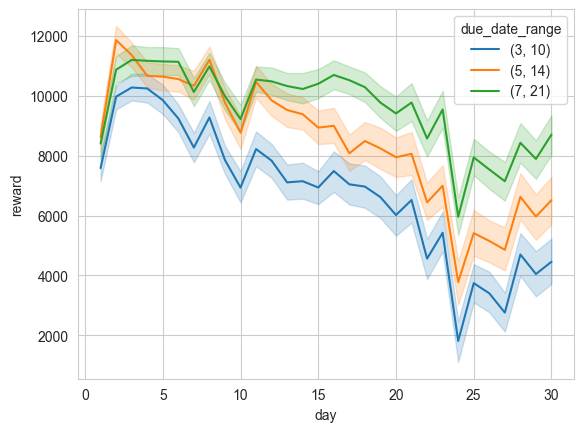

In [21]:
# Visualize profit per due date constellation
sns.lineplot(rewards_list_evaluation, x = "day", y = "reward", hue = "due_date_range")

<AxesSubplot: xlabel='day', ylabel='reward'>

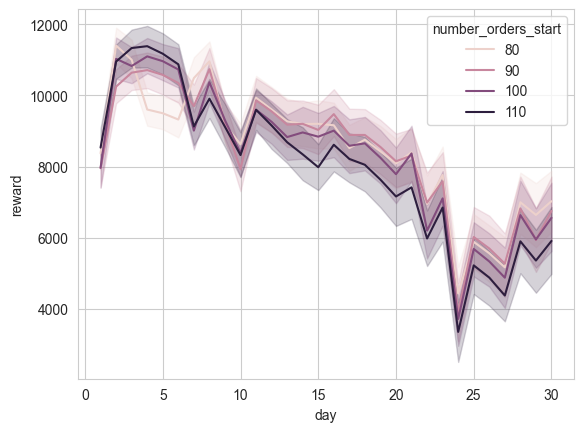

In [22]:
# Visualize profit per number_orders_start constellation
sns.lineplot(rewards_list_evaluation, x = "day", y = "reward", hue = "number_orders_start")

<AxesSubplot: xlabel='day', ylabel='reward'>

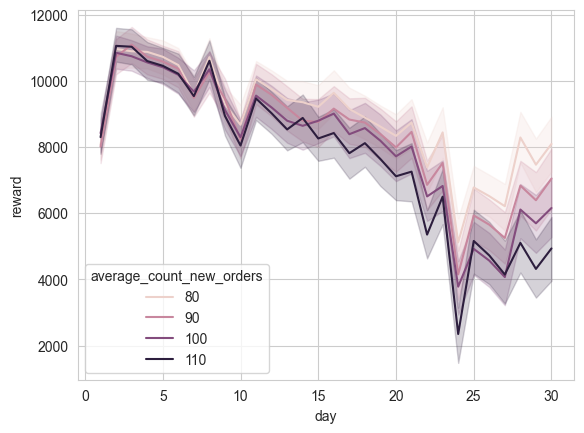

In [23]:
# Visualize profit per average count new orders constellation
sns.lineplot(rewards_list_evaluation, x = "day", y = "reward", hue = "average_count_new_orders")